In [3]:
!pip install numpy
!pip install pandas
!pip install librosa
!pip install matplotlib
!pip install seaborn
!pip install tensorflow
!pip install keras

import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
import IPython.display as ipd
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# データのロード
base_dir = "./"
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")
meta_data = pd.read_csv(meta_file)
data_size = meta_data.shape
print(data_size)

# ラベルとその名前のDataFrame
class_dict = {}
for i in range(data_size[0]):
    if meta_data.loc[i,"target"] not in class_dict.keys():
        class_dict[meta_data.loc[i,"target"]] = meta_data.loc[i,"category"]
class_pd = pd.DataFrame(list(class_dict.items()), columns=["labels","classes"])

# ダウンロードした音声データの読み込み用関数
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()
    
    
# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

(2000, 7)


wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


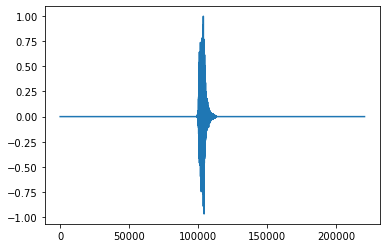

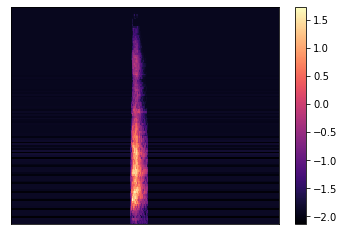

In [5]:
# サンプル音声データをロード
x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])

# 音声をメル周波数に変換
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

# 実際にjupyter上で音声が聞ける
ipd.Audio(x, rate=fs)



wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


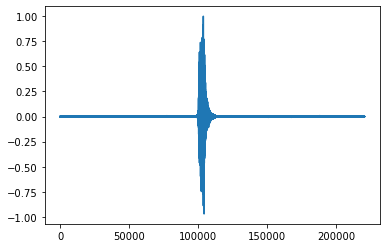

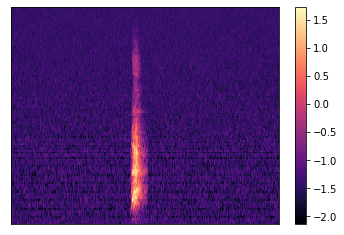

In [6]:
# add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

x_wn = add_white_noise(x)
melsp = calculate_melsp(x_wn)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_wn.shape, melsp.shape, fs))
show_wave(x_wn)
show_melsp(melsp, fs)

In [7]:
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

x_ss = shift_sound(x)
melsp = calculate_melsp(x_ss)

In [8]:
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")
    
x_st = stretch_sound(x)
melsp = calculate_melsp(x_st)

In [9]:
freq = 128
time = 1723

# save wave data in npz, with augmentation
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(audio_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)

# get training dataset and target dataset
x = list(meta_data.loc[:,"filename"])
y = list(meta_data.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train), len(y_train), len(x_test), len(y_test)))

x train:1500
y train:1500
x test:500
y test:500


In [10]:
# save training dataset with white noise
if not os.path.exists("esc_melsp_train_wn.npz"):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data("esc_melsp_train_wn.npz", x_train,  y_train, aug=add_white_noise, rates=rates)

# save training dataset with sound shift
if not os.path.exists("esc_melsp_train_ss.npz"):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data("esc_melsp_train_ss.npz", x_train,  y_train, aug=shift_sound, rates=rates)

# save training dataset with stretch
if not os.path.exists("esc_melsp_train_st.npz"):
    rates = np.random.choice(np.arange(80,120),len(y_train))/100
    save_np_data("esc_melsp_train_st.npz", x_train,  y_train, aug=stretch_sound, rates=rates)

In [11]:
# save training dataset with combination of white noise and shift or stretch
if not os.path.exists("esc_melsp_train_com.npz"):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(audio_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez("esc_melsp_train_com.npz", x=np_data, y=np_targets)

In [12]:
# dataset files
train_files = ["esc_melsp_train_raw.npz",  "esc_melsp_train_ss.npz", "esc_melsp_train_st.npz", 
               "esc_melsp_train_wn.npz", "esc_melsp_train_com.npz"]
test_file = "esc_melsp_test.npz"

In [13]:
freq = 128
time = 1723

train_num = 1500
test_num = 500

# データセット用placeholderの定義
x_train = np.zeros(freq*time*train_num*len(train_files)).reshape(train_num*len(train_files), freq, time)
y_train = np.zeros(train_num*len(train_files))

# ファイルからtrain/testデータ読み込み
for i in range(len(train_files)):
    data = np.load(train_files[i])
    x_train[i*train_num:(i+1)*train_num] = data["x"]
    y_train[i*train_num:(i+1)*train_num] = data["y"]

test_data = np.load(test_file)
x_test = test_data["x"]
y_test = test_data["y"]

# ラベルをone-hotに変換
classes = 50
y_train = keras.utils.to_categorical(y_train, classes)
y_test = keras.utils.to_categorical(y_test, classes)

# CNN用にデータを(batch_size, freq, time, 1)にreshape
x_train = x_train.reshape(train_num*5, freq, time, 1)
x_test = x_test.reshape(test_num, freq, time, 1)

print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x train:(7500, 128, 1723, 1)
y train:(7500, 50)
x test:(500, 128, 1723, 1)
y test:(500, 50)


In [14]:
def cba(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# Callbackとか
model_dir = "./ESC-50-master/dir"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = os.path.join(model_dir, 'esc50_.{epoch:02d}_{val_loss:.4f}_{val_accuracy:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# CNN
inputs = Input(shape=(x_train.shape[1:]))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

x = GlobalAveragePooling2D()(x)
x = Dense(classes)(x)
x = Activation("softmax")(x)

model = Model(inputs, x)

# initiate Adam optimizer with amsgrad
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6, amsgrad=True)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 1723, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 862, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 862, 32) 544         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 862, 32) 1056        input_1[0][0]                    
_______________________________________________________________________________________

In [14]:
# class data generator

class MixupGenerator():
    def __init__(self, x_train, y_train, batch_size=16, alpha=0.2, shuffle=True):
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(x_train)

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                x, y = self.__data_generation(batch_ids)

                yield x, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.x_train.shape
        _, class_num = self.y_train.shape
        x1 = self.x_train[batch_ids[:self.batch_size]]
        x2 = self.x_train[batch_ids[self.batch_size:]]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        x_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        x = x1 * x_l + x2 * (1 - x_l)
        y = y1 * y_l + y2 * (1 - y_l)

        return x, y

# 訓練
batch_size = 16
epochs = 10

training_generator = MixupGenerator(x_train, y_train)()
model.fit_generator(generator=training_generator, steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_test, y_test), epochs=epochs, 
                    verbose=1, shuffle=True, 
                    callbacks=[es_cb, cp_cb])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
  1/468 [..............................] - ETA: 0s - loss: 3.9066 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [16]:
from keras.models import load_model
model = load_model("./ESC-50-master/dir\esc50_.10_2.3302_0.4500.hdf5")

In [16]:
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

16/16 [==============================] - 61s 4s/step - loss: 2.3302 - accuracy: 0.4500
[2.330152750015259, 0.44999998807907104]


In [18]:
model.load_weights(os.path.join( "./ESC-50-master/dir\esc50_.10_2.3302_0.4500.hdf5"))

In [20]:
import matplotlib.pyplot as plt
# 学習実行
model.fit_generator(generator=training_generator, steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_test, y_test), epochs=1, 
                    verbose=1, shuffle=True, 
                    callbacks=[es_cb, cp_cb])

468/468 [==============================] - ETA: 0s - loss: 2.7416 - accuracy: 0.3904 
Epoch 00001: val_loss improved from inf to 2.27593, saving model to ./ESC-50-master/dir\esc50_.01_2.2759_0.4520.hdf5
468/468 [==============================] - 7799s 17s/step - loss: 2.7416 - accuracy: 0.3904 - val_loss: 2.2759 - val_accuracy: 0.4520


In [21]:
model = load_model("./ESC-50-master/dir\esc50_.01_2.2759_0.4520.hdf5")
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

16/16 [==============================] - 61s 4s/step - loss: 2.2759 - accuracy: 0.4520
[2.275926113128662, 0.4519999921321869]


In [ ]:
model.load_weights(os.path.join( "./ESC-50-master/dir\esc50_.01_2.2759_0.4520.hdf5"))
model.fit_generator(generator=training_generator, steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_test, y_test), epochs=6, 
                    verbose=1, shuffle=True, 
                    callbacks=[es_cb, cp_cb])

Epoch 1/6
468/468 [==============================] - ETA: 0s - loss: 2.7081 - accuracy: 0.4046 
Epoch 00001: val_loss improved from 2.27593 to 2.21224, saving model to ./ESC-50-master/dir\esc50_.01_2.2122_0.4760.hdf5
468/468 [==============================] - 8126s 17s/step - loss: 2.7081 - accuracy: 0.4046 - val_loss: 2.2122 - val_accuracy: 0.4760
Epoch 2/6
468/468 [==============================] - ETA: 0s - loss: 2.6681 - accuracy: 0.4151 
Epoch 00002: val_loss improved from 2.21224 to 2.18305, saving model to ./ESC-50-master/dir\esc50_.02_2.1830_0.4780.hdf5
468/468 [==============================] - 7652s 16s/step - loss: 2.6681 - accuracy: 0.4151 - val_loss: 2.1830 - val_accuracy: 0.4780
Epoch 3/6
468/468 [==============================] - ETA: 0s - loss: 2.6055 - accuracy: 0.4448 
Epoch 00003: val_loss improved from 2.18305 to 2.15056, saving model to ./ESC-50-master/dir\esc50_.03_2.1506_0.5140.hdf5
468/468 [==============================] - 7642s 16s/step - loss: 2.6055 - accura

In [17]:
model = load_model("./ESC-50-master/dir\esc50_.03_2.1506_0.5140.hdf5")
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

16/16 [==============================] - 61s 4s/step - loss: 2.1506 - accuracy: 0.5140
[2.1505649089813232, 0.5139999985694885]
